In [5]:
# 2017-10-03 baseline (only)                         --> LB=0.78
# 2017-10-03 baseline with lemmarization (pymorphy2) --> LB=0.83991
# 2017-10-03 baseline + lemmarization (pymorphy2)
# 2017-10-04 baseline + lemmarization (pymorphy2) + base
# 2017-10-05 baseline + lemmarization (pymorphy2) + base + XGB(natural) --> LB=0.8688
# 2017-10-07 baseline + lemmarization (pymorphy2) + base - stopWords XGB(natural) -> 0.8755666207002808

In [6]:
from __future__ import division
import pandas as pd
from collections import Counter
import functools
#import tqdm
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
import sklearn.metrics as skm
import sklearn.model_selection as skms
import pymorphy2

In [7]:
#dftrain, dftest = pd.read_csv("../Data/train_task1_latest.csv"), pd.read_csv("../Data/test_task1_latest.csv")
dftrain, dftest = pd.read_csv("../Work/train_task1_lemma.csv"), pd.read_csv("../Work/test_task1_lemma.csv")

In [8]:
dftrain.shape, dftest.shape, dftrain.columns.tolist()

((119398, 13),
 (74294, 12),
 ['paragraph_id',
  'question_id',
  'paragraph',
  'question',
  'target',
  'paragraphL',
  'questionL',
  'paragraphLS',
  'questionLS',
  'paragraphLX',
  'questionLX',
  'paragraphLSX',
  'questionLSX'])

In [9]:
'''
print(dftrain.paragraph[0])
mm2 = pymorphy2.MorphAnalyzer()
mm2.parse(u'вова')
print mm2.parse(u'вову')[0].normal_form

[mm2.parse(xx)[0].normal_form for xx in re.findall("\w+", (dftrain.paragraph[0]).decode('utf-8'),re.UNICODE) if mm2.parse(xx)[0].tag.POS in {'PREP','CONJ','PRCL'}] 
for xx in [mm2.parse(xx)[0].normal_form for xx in re.findall("\w+", (dftrain.paragraph[0]).decode('utf-8'),re.UNICODE) if mm2.parse(xx)[0].tag.POS not in {'PREP','CONJ','PRCL'}]  :
    print xx
'''


'\nprint(dftrain.paragraph[0])\nmm2 = pymorphy2.MorphAnalyzer()\nmm2.parse(u\'\xd0\xb2\xd0\xbe\xd0\xb2\xd0\xb0\')\nprint mm2.parse(u\'\xd0\xb2\xd0\xbe\xd0\xb2\xd1\x83\')[0].normal_form\n\n[mm2.parse(xx)[0].normal_form for xx in re.findall("\\w+", (dftrain.paragraph[0]).decode(\'utf-8\'),re.UNICODE) if mm2.parse(xx)[0].tag.POS in {\'PREP\',\'CONJ\',\'PRCL\'}] \nfor xx in [mm2.parse(xx)[0].normal_form for xx in re.findall("\\w+", (dftrain.paragraph[0]).decode(\'utf-8\'),re.UNICODE) if mm2.parse(xx)[0].tag.POS not in {\'PREP\',\'CONJ\',\'PRCL\'}]  :\n    print xx\n'

In [10]:
#@functools.lru_cache(maxsize=2 ** 19)
def uniq_words_old_baseline(text):
    return set(re.findall("\w+", text.decode('utf-8'),re.UNICODE))

def calculate_idfs_old_baseline(data):
    counter_paragraph = Counter()
    uniq_paragraphs = data['paragraph'].unique()
    for paragraph in uniq_paragraphs : #tqdm.tqdm(uniq_paragraphs, desc="calc idf"):
        set_words = uniq_words_old_baseline(paragraph)
        counter_paragraph.update(set_words)
        
    num_docs = uniq_paragraphs.shape[0]
    idfs = {}
    for word in counter_paragraph:
        idfs[word] = np.log(float(num_docs) // counter_paragraph[word])
    return idfs

In [11]:
#@functools.lru_cache(maxsize=2 ** 19)
def uniq_words(text):
    ttext = [mm2.parse(xx)[0].normal_form for xx in re.findall("\w+", text.decode('utf-8'),re.UNICODE) 
             if mm2.parse(xx)[0].tag.POS not in {'PREP','CONJ','PRCL','INTJ'}]
    return  set(ttext)
    #return set(re.findall("\w+", text.decode('utf-8'),re.UNICODE))

def calculate_idfs(data):
    counter_paragraph = Counter()
    uniq_paragraphs = data['paragraph'].unique()
    for paragraph in uniq_paragraphs : #tqdm.tqdm(uniq_paragraphs, desc="calc idf"):
        set_words = uniq_words(paragraph)
        counter_paragraph.update(set_words)
        
    num_docs = uniq_paragraphs.shape[0]
    idfs = {}
    for word in counter_paragraph:
        idfs[word] = np.log(float(num_docs) // counter_paragraph[word])
    return idfs

In [54]:
#@functools.lru_cache(maxsize=2 ** 19)
# add truncate 3 word
def uniq_wordsX(text, minLen=4):
    ttext = [xx for xx in re.findall("\w+", text.decode('utf-8'),re.UNICODE) if len(xx)>=minLen]
    return set(re.findall("\w+", text.decode('utf-8'),re.UNICODE))

def calculate_idfsX(data, column='paragraph'):
    counter_paragraph = Counter()
    uniq_paragraphs = data[column].unique()
    for paragraph in uniq_paragraphs : #tqdm.tqdm(uniq_paragraphs, desc="calc idf"):
        set_words = uniq_wordsX(paragraph)
        counter_paragraph.update(set_words)
        
    num_docs = uniq_paragraphs.shape[0]
    idfs = {}
    for word in counter_paragraph:
        idfs[word] = np.log(float(num_docs) // counter_paragraph[word])
    return idfs

In [55]:
idfs  = calculate_idfsX(dftrain,'paragraphLSX')
idfs0 = calculate_idfsX(dftrain,'paragraph')

In [56]:
dftrain[:1]

,paragraph_id,question_id,paragraph,question,target,paragraphL,questionL,paragraphLS,questionLS,paragraphLX,...,len_intersection,idf_question,idf_paragraph,idf_intersection,len_paragraph0,len_question0,len_intersection0,idf_question0,idf_paragraph0,idf_intersection0
0,1094,46273,"В отличие от рыб, земноводные (амфибии) и прес...",С какого года Русское Царство перешло на летои...,0.0,"в отличие от рыба , земноводный ( амфибия ) и ...",с какой год русский царство перейти на летоисч...,"отличие рыба , земноводный ( амфибия ) пресмык...",год русский царство перейти летоисчисление рож...,"отличие рыба , земноводный ( амфибия ) пресмык...",...,0.0,56.729073,255.420678,0.0,67.0,19.0,3.0,81.077319,352.850226,1.791759


In [57]:
#print(dftrain.paragraph[0])

In [58]:
#paragraph = uniq_words(str(dftrain.paragraph[0]));
#print len(paragraph)
#for xx in paragraph : print xx

In [59]:
for name, df in [('train', dftrain), ('test', dftest)]:
    for index, row in df.iterrows() : #tqdm.tqdm(df.iterrows(), total=df.shape[0], desc="build features for " + name):
        
        question  = uniq_wordsX(row.questionLSX)
        paragraph = uniq_wordsX(row.paragraphLSX)
        df.loc[index, 'len_paragraph'] = len(paragraph)
        df.loc[index, 'len_question'] = len(question)
        df.loc[index, 'len_intersection'] = len(paragraph & question)
        df.loc[index, 'idf_question'] = np.sum([idfs.get(word, 0.0) for word in question])
        df.loc[index, 'idf_paragraph'] = np.sum([idfs.get(word, 0.0) for word in paragraph])
        df.loc[index, 'idf_intersection'] = np.sum([idfs.get(word, 0.0) for word in paragraph & question])
        
        question  = uniq_wordsX(row.question)
        paragraph = uniq_wordsX(row.paragraph)
        df.loc[index, 'len_paragraph0'] = len(paragraph)
        df.loc[index, 'len_question0'] = len(question)
        df.loc[index, 'len_intersection0'] = len(paragraph & question)
        df.loc[index, 'idf_question0'] = np.sum([idfs0.get(word, 0.0) for word in question])
        df.loc[index, 'idf_paragraph0'] = np.sum([idfs0.get(word, 0.0) for word in paragraph])
        df.loc[index, 'idf_intersection0'] = np.sum([idfs0.get(word, 0.0) for word in paragraph & question])

In [60]:
dftrain.tail()

,paragraph_id,question_id,paragraph,question,target,paragraphL,questionL,paragraphLS,questionLS,paragraphLX,...,len_intersection,idf_question,idf_paragraph,idf_intersection,len_paragraph0,len_question0,len_intersection0,idf_question0,idf_paragraph0,idf_intersection0
119393,787,78704,"С VIII века, как для Везера, так и для Верра, ...",Какие новые спортивные сооружения были построе...,0.0,"с viii век , как для везер , так и для верра ,...",какой новое спортивный сооружение быть построи...,"viii век , везер , верра , передаваться поколе...",новое спортивный сооружение построить универси...,"viii век , везер , верра , передаваться поколе...",...,0.0,31.905366,521.613527,0.000000,134.0,11.0,3.0,39.611780,729.865475,3.044522
119394,7414,97752,В 1049 году Балдуину V удалось отнять у Герман...,В каком году умер Райан Уайт?,0.0,в 1049 год балдуин v удаться отнять у германия...,в какой год умереть райан уайт ?,1049 год балдуин v удаться отнять германия час...,год умереть райан уайт ?,1049 год балдуин v удаться отнять германия час...,...,2.0,20.930153,336.687899,5.411646,89.0,6.0,3.0,28.438558,496.188281,6.473891
119395,3845,2104,Клиническая фармакология изучает воздействие л...,Когда на всемирном конгрессе немецких школ за ...,0.0,клинический фармакология изучать воздействие л...,когда на всемирный конгресс немецкий школа за ...,клинический фармакология изучать воздействие л...,всемирный конгресс немецкий школа рубеж предст...,клинический фармакология изучать воздействие л...,...,0.0,37.792184,240.341321,0.000000,74.0,14.0,3.0,66.305302,381.707501,4.941642
119396,168,92509,Сложность выделения чистых белков затрудняла и...,Что в конце 1940-х — начале 1950-х годов разра...,0.0,сложность выделение чистый белок затруднять он...,что в конец 1940-ха — начало 1950-ха год разра...,сложность выделение чистый белок затруднять из...,конец 1940-ха — начало 1950-ха год разработать...,сложность выделение чистый белок затруднять он...,...,2.0,25.659151,223.153311,3.258097,63.0,11.0,5.0,50.299845,324.672574,13.735103
119397,2679,41770,"У типичной свободной программы (то есть, неком...",с каким персонажем происходит схватка Шерлока ...,0.0,"у типичный свободный программа ( то есть , нек...",с какой персонаж происходить схватка шерлок хо...,"типичный свободный программа ( , некоммерчески...",персонаж происходить схватка шерлок холмс филь...,"типичный свободный программа ( , некоммерчески...",...,0.0,51.723335,257.646193,0.000000,86.0,13.0,3.0,68.846945,442.699187,0.000000


In [71]:
import xgboost as xgb
columns  = []
columns += ['len_paragraph', 'len_question', 'len_intersection', 'idf_question', 'idf_paragraph', 'idf_intersection']
columns += ['len_paragraph0', 'len_question0', 'len_intersection0', 'idf_question0', 'idf_paragraph0', 'idf_intersection0']
#model = GradientBoostingClassifier()
model = xgb.XGBClassifier(learning_rate=0.1, n_estimators=900, silent=True).fit(dftrain[columns], dftrain['target'])
#model = GradientBoostingClassifier().fit(dftrain[columns], dftrain['target'])
dftest['prediction']  = model.predict_proba(dftest[columns])[:, 1]
ddftrain = model.predict_proba(dftrain[columns])[:, 1]

In [72]:
dftest[['paragraph_id', 'question_id', 'prediction']].head()

,paragraph_id,question_id,prediction
0,1361,6463,0.000012
1,1403,34696,0.700277
2,1435,13751,0.002335
3,341,38544,0.999482
4,1317,14589,0.006904


In [74]:
dftest[['paragraph_id', 'question_id', 'prediction']].to_csv("../Result/prediction-2017-10-08-00-10.csv", index=False)

In [52]:
dftrain.target[:10]
ddftrain[:10]

array([  8.01344595e-06,   1.67586407e-07,   1.09849652e-05,
         4.38361676e-05,   5.30144632e-01,   1.79525273e-06,
         7.36293878e-05,   9.93215561e-01,   9.99737799e-01,
         7.50693216e-05], dtype=float32)

accuracy=0.98976 roc_auc=0.98807


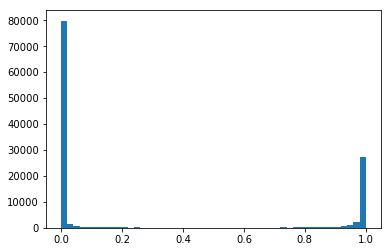

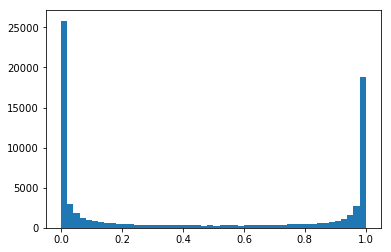

In [73]:
print 'accuracy={:.5f} roc_auc={:.5f}'.format(skm.accuracy_score(dftrain['target'].values,ddftrain>0.5),
           skm.roc_auc_score(dftrain['target'].values,ddftrain>0.5))
plt.hist(ddftrain,bins=50); plt.show()
plt.hist(dftest['prediction'],bins=50); plt.show()

accuracy=0.98549 roc_auc=0.98326


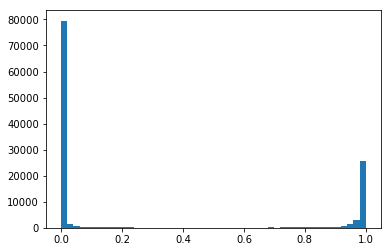

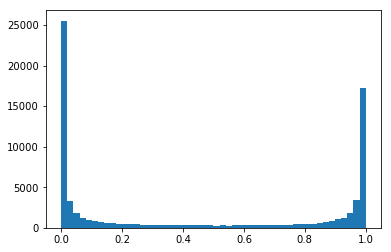

In [38]:
print 'accuracy={:.5f} roc_auc={:.5f}'.format(skm.accuracy_score(dftrain['target'].values,ddftrain>0.5),
           skm.roc_auc_score(dftrain['target'].values,ddftrain>0.5))
plt.hist(ddftrain,bins=50); plt.show()
plt.hist(dftest['prediction'],bins=50); plt.show()

0.973935911824


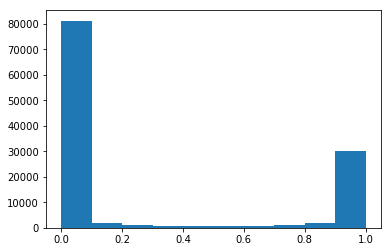

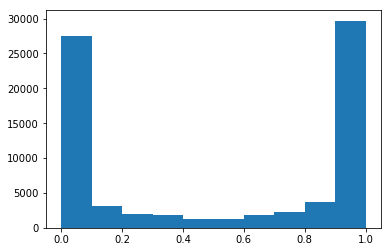

In [145]:
print skm.accuracy_score(dftrain['target'].values,ddftrain>0.5)
plt.hist(ddftrain); plt.show()
plt.hist(dftest['prediction']); plt.show()

In [28]:
aa=Counter('aabb bcccc'); aa
#aa=Counter({'aa':6, 'b':7}); aa

Counter({' ': 1, 'a': 2, 'b': 3, 'c': 4})

In [85]:
import pymorphy2
morphy = pymorphy2.MorphAnalyzer()
morphy.parse(u'вова')
print morphy.parse(u'вову')[0].normal_form
#str(morphy.parse(u'вовочка')[0].normal_form) #.encode('cp1251')

вова


In [112]:
wword = u'четвертый пересидевший'
print len(morphy.parse(wword)),morphy.parse(wword)
print morphy.parse(wword)[0].normal_form
for pp in morphy.parse(wword) : print pp.normal_form, pp.score, pp.tag

4 [Parse(word=u'\u0447\u0435\u0442\u0432\u0435\u0440\u0442\u044b\u0439 \u043f\u0435\u0440\u0435\u0441\u0438\u0434\u0435\u0432\u0448\u0438\u0439', tag=OpencorporaTag('PRTF,perf,intr,past,actv masc,sing,nomn'), normal_form=u'\u0447\u0435\u0442\u0432\u0435\u0440\u0442\u044b\u0439 \u043f\u0435\u0440\u0435\u0441\u0438\u0434\u0435\u0442\u044c', score=0.4831932773109244, methods_stack=((<FakeDictionary>, u'\u0447\u0435\u0442\u0432\u0435\u0440\u0442\u044b\u0439 \u043f\u0435\u0440\u0435\u0441\u0438\u0434\u0435\u0432\u0448\u0438\u0439', 715, 15), (<KnownSuffixAnalyzer>, u'\u0435\u0432\u0448\u0438\u0439'))), Parse(word=u'\u0447\u0435\u0442\u0432\u0435\u0440\u0442\u044b\u0439 \u043f\u0435\u0440\u0435\u0441\u0438\u0434\u0435\u0432\u0448\u0438\u0439', tag=OpencorporaTag('PRTF,perf,intr,past,actv inan,masc,sing,accs'), normal_form=u'\u0447\u0435\u0442\u0432\u0435\u0440\u0442\u044b\u0439 \u043f\u0435\u0440\u0435\u0441\u0438\u0434\u0435\u0442\u044c', score=0.4831932773109244, methods_stack=((<FakeDicti

In [75]:
print unicode(u'вщвщчка')
#str(u'вщвщчка'.decode('utf_8'))

вщвщчка


In [74]:
print 'вовочка'.decode('utf-8')

вовочка


In [200]:
import nltk

In [217]:
dftrain.columns

Index([u'paragraph_id', u'question_id', u'paragraph', u'question', u'target',
       u'len_paragraph', u'len_question', u'len_intersection', u'idf_question',
       u'idf_paragraph', u'idf_intersection', u'len_paragraph0',
       u'len_question0', u'len_intersection0', u'idf_question0',
       u'idf_paragraph0', u'idf_intersection0'],
      dtype='object')

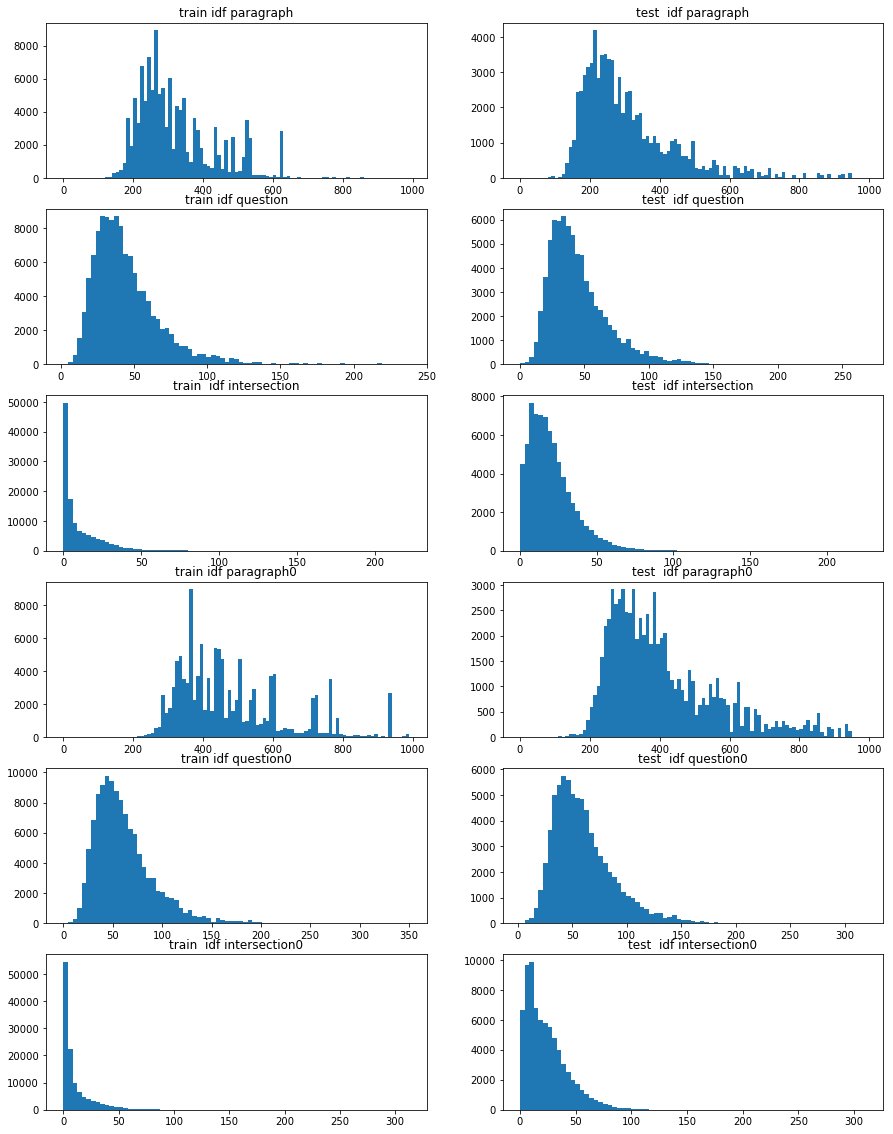

In [253]:
plt.figure(figsize=(15,20))
bbins = [xx for xx in range(0,1000,10)]
plt.subplot(621); plt.hist(dftrain.idf_paragraph,bins=bbins); plt.title('train idf paragraph')
plt.subplot(622);plt.hist(dftest.idf_paragraph,bins=bbins);   plt.title('test  idf paragraph') 
plt.subplot(623); plt.hist(dftrain.idf_question,bins=75);     plt.title('train idf question')
plt.subplot(624);plt.hist(dftest.idf_question,bins=75);       plt.title('test  idf question')
plt.subplot(625);plt.hist(dftrain.idf_intersection,bins=75);       plt.title('train  idf intersection')
plt.subplot(626);plt.hist(dftest.idf_intersection,bins=75);       plt.title('test  idf intersection')

plt.subplot(627); plt.hist(dftrain.idf_paragraph0,bins=bbins);plt.title('train idf paragraph0')
plt.subplot(628);plt.hist(dftest.idf_paragraph0,bins=bbins);  plt.title('test  idf paragraph0')
plt.subplot(629); plt.hist(dftrain.idf_question0,bins=75);    plt.title('train idf question0')
plt.subplot(6,2,10);plt.hist(dftest.idf_question0,bins=75);      plt.title('test  idf question0')
plt.subplot(6,2,11);plt.hist(dftrain.idf_intersection0,bins=75);      plt.title('train  idf intersection0')
plt.subplot(6,2,12);plt.hist(dftest.idf_intersection0,bins=75);      plt.title('test  idf intersection0')

plt.show()

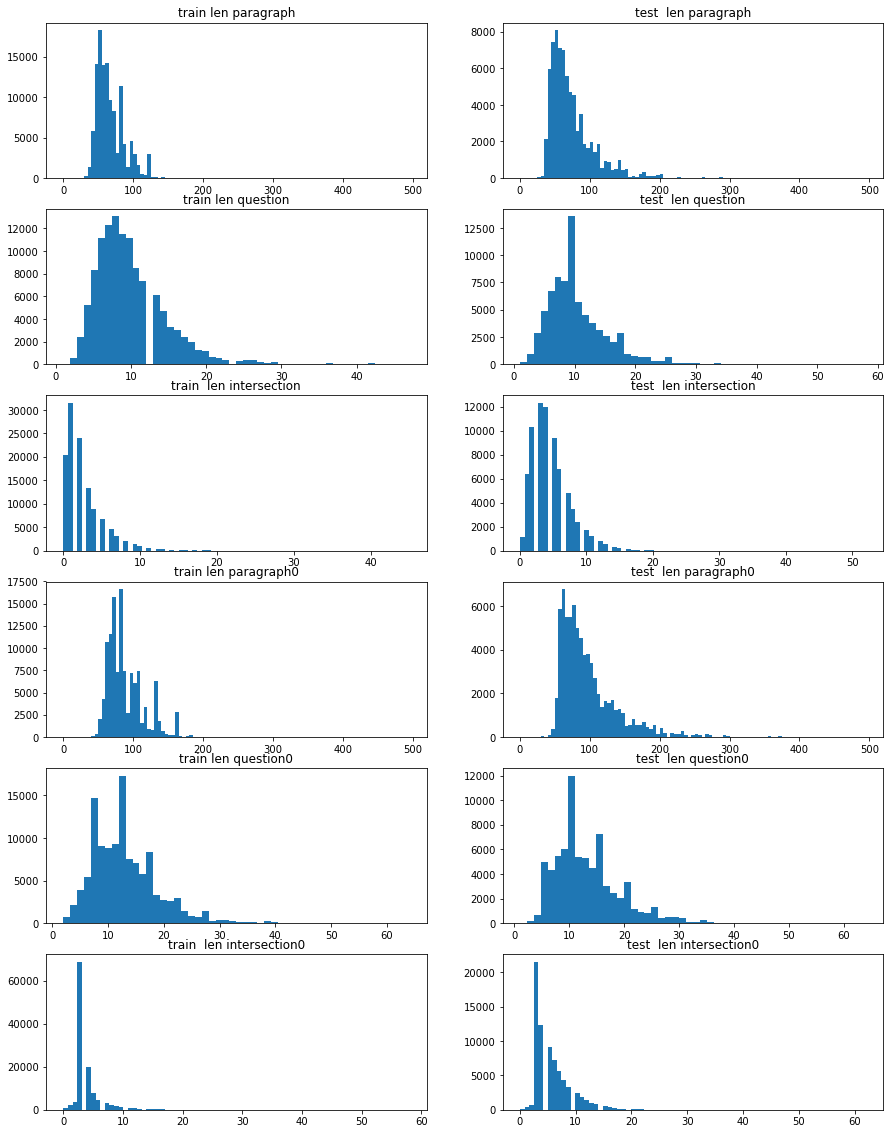

In [252]:
plt.figure(figsize=(15,20))
bbins = [xx for xx in range(0,500,5)]
plt.subplot(621); plt.hist(dftrain.len_paragraph,bins=bbins); plt.title('train len paragraph')
plt.subplot(622);plt.hist(dftest.len_paragraph,bins=bbins);   plt.title('test  len paragraph') 
plt.subplot(623); plt.hist(dftrain.len_question,bins=50);     plt.title('train len question')
plt.subplot(624);plt.hist(dftest.len_question,bins=50);       plt.title('test  len question')
plt.subplot(625);plt.hist(dftrain.len_intersection,bins=75);       plt.title('train  len intersection')
plt.subplot(626);plt.hist(dftest.len_intersection,bins=75);       plt.title('test  len intersection')

plt.subplot(627); plt.hist(dftrain.len_paragraph0,bins=bbins);plt.title('train len paragraph0')
plt.subplot(628);plt.hist(dftest.len_paragraph0,bins=bbins);  plt.title('test  len paragraph0')
plt.subplot(629); plt.hist(dftrain.len_question0,bins=50);    plt.title('train len question0')
plt.subplot(6,2,10);plt.hist(dftest.len_question0,bins=50);      plt.title('test  len question0')
plt.subplot(6,2,11);plt.hist(dftrain.len_intersection0,bins=75);      plt.title('train  len intersection0')
plt.subplot(6,2,12);plt.hist(dftest.len_intersection0,bins=75);      plt.title('test  len intersection0')

plt.show()

In [274]:
skf = skms.StratifiedKFold(n_splits=3)
X = [11,22,33,44,55,66,77,88,99,10]; 
y = [11,11,11,11,11,22,22,22,22,22]; 
print(X)
for train_index, test_index in skf.split(X,y) :
    print 'train={} test={}'.format(train_index,test_index)
    print np.array(X)[train_index]
    print np.array(X)[test_index]


[11, 22, 33, 44, 55, 66, 77, 88, 99, 10]
train=[2 3 4 7 8 9] test=[0 1 5 6]
[33 44 55 88 99 10]
[11 22 66 77]
train=[0 1 4 5 6 9] test=[2 3 7 8]
[11 22 55 66 77 10]
[33 44 88 99]
train=[0 1 2 3 5 6 7 8] test=[4 9]
[11 22 33 44 66 77 88 99]
[55 10]


In [336]:
skf = skms.StratifiedKFold(n_splits=10)
import xgboost as xgb
columns  = []
columns += ['len_paragraph', 'len_question', 'len_intersection', 'idf_question', 'idf_paragraph', 'idf_intersection']
columns += ['len_paragraph0', 'len_question0', 'len_intersection0', 'idf_question0', 'idf_paragraph0', 'idf_intersection0']
#model = GradientBoostingClassifier()
model = xgb.XGBClassifier(learning_rate=0.1, n_estimators=300, silent=True)
scores = skms.cross_val_score(model, dftrain[columns], dftrain['target'], cv=skf, scoring='roc_auc');
#dftest['prediction']  = model.predict_proba(dftest[columns])[:, 1]
#ddftrain = model.predict_proba(dftrain[columns])[:, 1]
np.array(scores).mean(), np.array(scores).std(), scores

(0.99839152723779545,
 0.00012748411913640487,
 array([ 0.99834759,  0.99852797,  0.99835356,  0.99835328,  0.99859732,
         0.99834908,  0.99856697,  0.99815247,  0.99832212,  0.99834491]))

In [335]:
np.array(scores).mean(), np.array(scores).std(), scores

(0.99835128988464183,
 0.00013363048368364195,
 array([ 0.99830495,  0.99850091,  0.99830191,  0.99829347,  0.99856759,
         0.99828593,  0.99852408,  0.99809739,  0.99833713,  0.99829954]))